For any $m \ge 5$, there is a polynomial $p(z)$ of degree $m$ with rational cosefficients that has a real root $p(r)=0$ with the property that $r$ cannot be written using any expression involving rational numbers, addition, substraction, multiplication, division, and k-th root.

This theorem implies even we counld work in exact arithmetic, there counld be no copmuter program that would produce the exact roots of an arbitrary polynomial in a finite number of steps. 

So we cannot use methods like Householder reflections or Gaussian eliminatino to solve linear system in a finite number of steps if implemented in exact arithmetic. Any eigenvalue solver must be iterative. 

The goal of eigenvalue solver: produce sequences of numbers that converge rapidly towards eigenvalues. 

<br>

2 phases of eigenvalue computations:
1. Produce an upper-Hessenberg matrix $H$, that is a matrix with zeros below the first subdiagonal. $O(m^3)$ flops. 
2. Iteration to generate a formally inifinte sequence of Hessenberg matrices that converge to a traingular form. In practice, convergence to machine precision is achieved in $O(m)$ ietarations. Each iteration requires $O(m^2)$. Total $O(m^3)$ flops. 

### Hessenberg Form

### Rayleigh quotient is defined as:

ValueError: Contour levels must be increasing

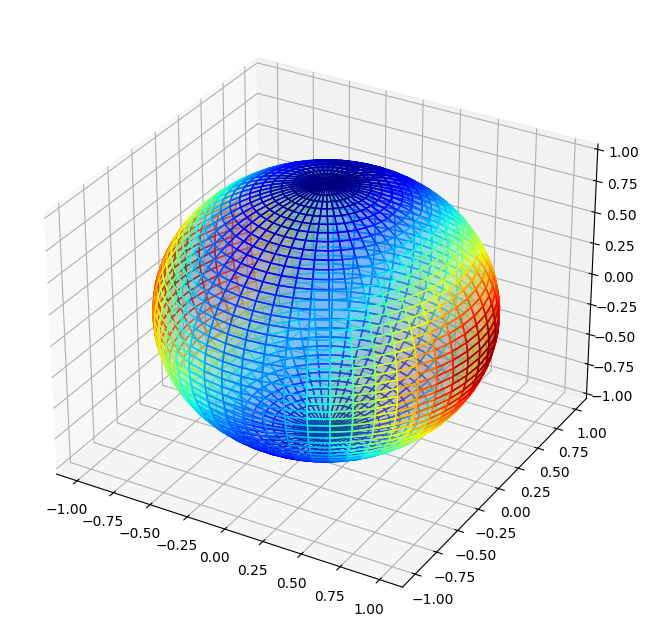

In [1]:
# contour plot of Rayleigh quotient
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_rayleigh_quotient():
    # Define the matrix A as specified in Slide 8
    # A = diag(1, 0.25, 0)
    A = np.diag([1.0, 0.25, 0.0])

    # Create a meshgrid for the unit sphere using spherical coordinates
    # phi: polar angle, theta: azimuthal angle
    phi = np.linspace(0, np.pi, 50)
    theta = np.linspace(0, 2 * np.pi, 50)
    phi, theta = np.meshgrid(phi, theta)

    # Convert spherical to cartesian coordinates (x, y, z)
    # This ensures x^T x = 1 (vectors are on the unit sphere)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    # Calculate Rayleigh Quotient for each point on the sphere
    # R(x) = (x^T A x) / (x^T x). Since vectors are normalized, denominator is 1.
    # Calculation: x* (A[0,0]*x + ...) + y*...
    # For diagonal A, this simplifies to: A[0,0]*x^2 + A[1,1]*y^2 + A[2,2]*z^2
    R = A[0,0]*x**2 + A[1,1]*y**2 + A[2,2]*z**2

    # Set up the plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface with color mapped to the Rayleigh Quotient value
    surf = ax.plot_surface(x, y, z, facecolors=plt.cm.jet(R),
                           rstride=1, cstride=1, alpha=0.3, shade=False)

    # Add contours projected onto the sphere surface
    # We plot contours at specific levels of R
    levels = np.linspace(np.min(R), np.max(R), 15)
    ax.contour(x, y, z, R, zdir='z', offset=-1.5, cmap='jet') # Projection on bottom
    ax.contour3D(x, y, z, R, levels=levels, cmap='jet', linewidths=2)

    # Formatting axes to look like Slide 8
    ax.set_xlabel('$x = e_1$')
    ax.set_ylabel('$y = e_2$')
    ax.set_zlabel('$z = e_3$')
    ax.set_title('Contour Plot of Rayleigh Quotient on Unit Sphere')

    # Adjust view angle similar to the slide
    ax.view_init(elev=30, azim=45)

    plt.show()


plot_rayleigh_quotient()

### power iteration:

In [ ]:
import numpy as np

def power_iteration(A, num_simulations=10):
    """
    Implements Power Iteration (Slide 12)
    Converges to the eigenvalue with the largest absolute value.
    """
    print(f"--- Power Iteration (n={num_simulations}) ---")
    n, _ = A.shape

    # 1. Initialize v(0) with norm 1 [cite: 105]
    np.random.seed(42) # For reproducibility
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)

    lam_prev = 0

    for k in range(1, num_simulations + 1):
        # 2. w = A v(k-1) [cite: 107]
        w = np.dot(A, v)

        # 3. v(k) = w / ||w|| [cite: 108]
        v = w / np.linalg.norm(w)

        # 4. lambda(k) = v(k).T * A * v(k) [cite: 109]
        lam = np.dot(v.T, np.dot(A, v))

        print(f"Iter {k}: Lambda = {lam:.6f}")
        lam_prev = lam

    return lam, v

### inverse iteration:

In [ ]:
def inverse_iteration(A, mu, num_simulations=10):
    """
    Implements Inverse Iteration (Slide 14)
    Converges to the eigenvalue closest to the shift mu.
    """
    print(f"\n--- Inverse Iteration (mu={mu}, n={num_simulations}) ---")
    n, _ = A.shape

    # 1. Initialize v(0) with norm 1 [cite: 129]
    np.random.seed(42)
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)

    I = np.eye(n)

    for k in range(1, num_simulations + 1):
        # 2. Solve (A - mu*I)w = v(k-1) [cite: 131]
        try:
            w = np.linalg.solve(A - mu * I, v)
        except np.linalg.LinAlgError:
            print("Matrix is singular (mu is exactly an eigenvalue).")
            break

        # 3. v(k) = w / ||w|| [cite: 132]
        v = w / np.linalg.norm(w)

        # 4. lambda(k) = v(k).T * A * v(k) [cite: 133]
        lam = np.dot(v.T, np.dot(A, v))

        print(f"Iter {k}: Lambda = {lam:.6f}")

    return lam, v

### Rayleigh Quotient iteration

Proof of cubic convergence of Rayleigh quotient iteration:

![截屏2025-12-07 15.23.52.png](<attachment:截屏2025-12-07 15.23.52.png>)

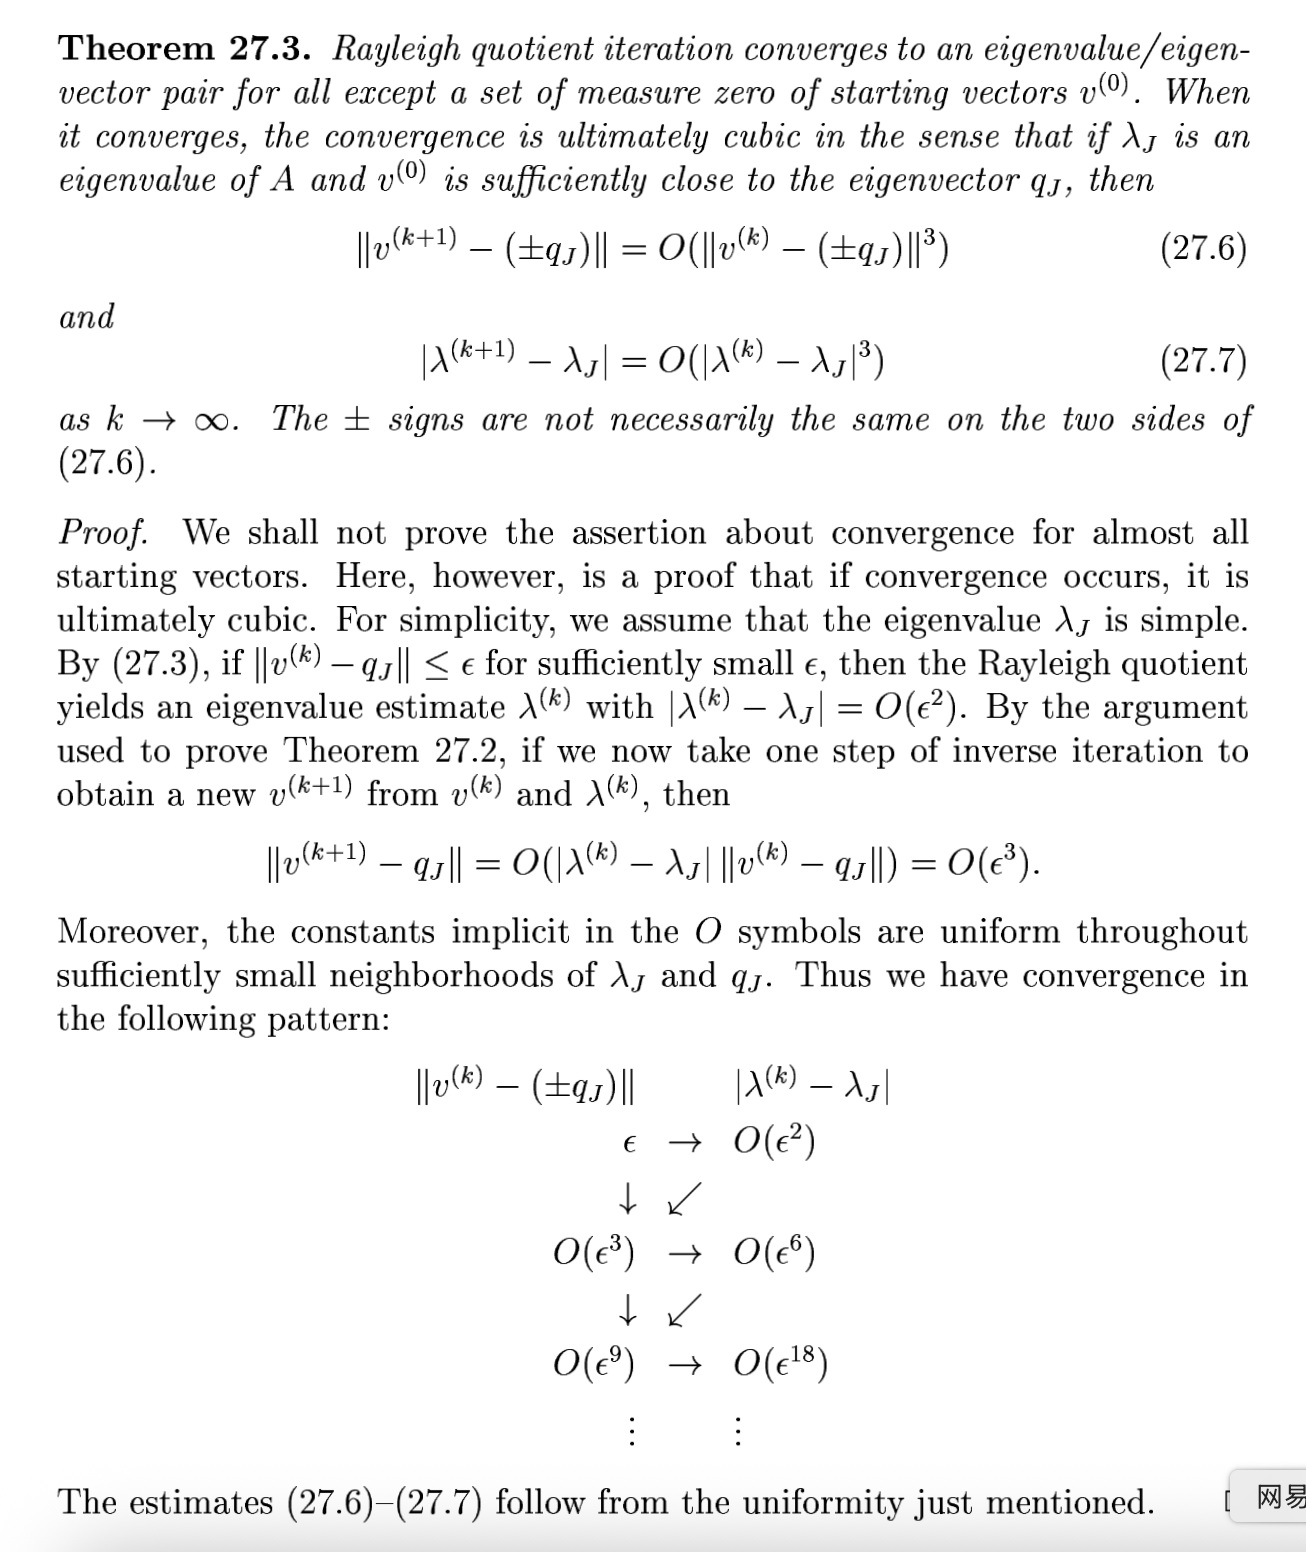

In [ ]:
def rayleigh_quotient_iteration(A, num_simulations=10):
    """
    Implements Rayleigh Quotient Iteration (Slide 15)
    Shift mu is updated at every step. Cubic convergence.
    """
    print(f"\n--- Rayleigh Quotient Iteration (n={num_simulations}) ---")
    n, _ = A.shape
    
    # 1. Initialize v(0) with norm 1 [cite: 149]
    np.random.seed(42)
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    
    # 2. Initial Lambda = Rayleigh Quotient of v(0) [cite: 150]
    lam = np.dot(v.T, np.dot(A, v))
    print(f"Iter 0: Initial Lambda = {lam:.6f}")
    
    I = np.eye(n)
    
    for k in range(1, num_simulations + 1):
        # 3. Solve (A - lambda(k-1)*I)w = v(k-1) [cite: 152]
        try:
            # Note: As we converge, matrix becomes singular. 
            # In practice, usually handled by least squares or adding tiny epsilon.
            w = np.linalg.solve(A - lam * I, v)
        except np.linalg.LinAlgError:
            print("Converged! (Matrix singular).")
            break
            
        # 4. v(k) = w / ||w|| [cite: 153]
        v = w / np.linalg.norm(w)
        
        # 5. Update lambda(k) = v(k).T * A * v(k) [cite: 153]
        lam = np.dot(v.T, np.dot(A, v))
        
        print(f"Iter {k}: Lambda = {lam:.15f}") # High precision to show cubic convergence
        
    return lam, v

### Comparison

Both three are for eigenvalue decomposition approximation

In [ ]:
A = np.diag([1.0, 0.25, 0.0])
    
# 1. Power Iteration (Should find max eigenvalue: 1.0)
power_iteration(A)
    
# 2. Inverse Iteration (Targeting eigenvalue near 0.2, should find 0.25)
inverse_iteration(A, mu=0.2)
    
# 3. Rayleigh Quotient Iteration (Should converge very fast to one of them)
rayleigh_quotient_iteration(A)